In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/
!git clone https://github.com/cl3789/Material-Morphing-toolkit-git.git

/content
Cloning into 'Material-Morphing-toolkit-git'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 95 (delta 16), reused 88 (delta 9), pack-reused 0
Receiving objects: 100% (95/95), 32.32 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
# Move to Material-Morphing-toolkit-git. And download StyleGAN3
%cd /content/Material-Morphing-toolkit-git
!git clone https://github.com/NVlabs/stylegan3.git


/content/Material-Morphing-toolkit-git
Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.16 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [4]:
#@markdown Import dependencies
#!pip install click requests pyspng tqdm pyopengl==3.1.5 ninja==1.10.2 imageio-ffmpeg==0.4.3 imgui==1.3.0
!pip install click requests pyspng tqdm pyopengl==3.1.5 ninja==1.10.2 imageio-ffmpeg==0.4.3

import argparse
import os
import pickle
import re
from os import listdir,makedirs
from os.path import isfile,join

from material_morphing import MergeDomains,generate_from_w ## Imoport the Material Morphing module

import numpy as np

from typing import List, Optional

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, interact

%matplotlib inline

import random
import itertools

import sys
sys.path.append('/content/Material-Morphing-toolkit-git/stylegan3')
import dnnlib, legacy
import PIL.Image
import torch
print(torch.version.cuda)
print(torch.__version__)
print(torch.cuda.get_device_name(device=None))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: pyopengl
    Found existing installation: PyOpenGL 3.1.7
    Uninstalling PyOpenGL-3.1.7:
      Successfully uninstalled PyOpenGL-3.1.7
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9
12.1
2.2.1+cu121
Tesla T4


In [5]:
# @title Utility functions
def loading_network(network_pkl):
  """Load the pretrained StyleGAN generator"""
  print('Loading networks from "%s"...' % network_pkl)
  device = torch.device('cuda')
  with dnnlib.util.open_url(network_pkl) as f:
      G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

  return G



def plot_subplot(img_list, n_row, n_col, width, height):
    """Create (x_row, n_col) subplot of a list of images"""
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(width, height))
    plt.subplots_adjust(hspace = .001)

    count = -1

    if n_row==1:
      for j in range(n_col):
        count = count+1
        axes[j].imshow(img_list[count])
        axes[j].grid(False)
        axes[j].set_xticks([])
        axes[j].set_yticks([])

    else:
      for i in range(n_row):
          for j in range(n_col):
              count = count+1
              axes[i,j].imshow(img_list[count]) ## show image
              axes[i,j].grid(False)
              axes[i,j].set_xticks([])
              axes[i,j].set_yticks([])
              axes[i,j].set_title(f'seed({count}), image_num({count+1})', size='small')

    fig.tight_layout()
    plt.show()



def save_img_from_list(img_list, save_names, outdir):
  """Save a list of PIL image to the path (outdir)"""
  try:
    makedirs(outdir)

  except:
      print ("Directory already exist, images will be written in same folder")

  for i, img_name in enumerate(save_names):
    print(i, img_name)
    img = img_list[i].resize((512,512))
    img.save(f'{outdir}/{img_name}.png')
  print("Finished saving images in:", outdir)


# Load the Pretrained Material Generators

In [6]:
## Model path. Change the path to your Local file directory.
# Will need to change the model path accordingly
G_soap_path = "/content/drive/MyDrive/StyleGAN2-multidomain/soap/training-resume-soap8k-day9-403pkl/00000-stylegan2-soap_8k_1024res-gpus1-batch4-gamma10/network-snapshot-soap8k-day9-403-pytorch.pkl"
G_rock_path = "/content/drive/MyDrive/StyleGAN2-multidomain/crystal_3k_new/training-day1-save1/00000-stylegan2-crystal_3k_1024res_new-gpus1-batch4-gamma10/network-snapshot-000280.pkl"
G_toy_path = "/content/drive/MyDrive/StyleGAN2-multidomain/toy_2k/training-day2-save1/00000-stylegan2-toy_2k_1024res_new-gpus1-batch4-gamma10/network-snapshot-000100.pkl"

## Load models
G_soap = loading_network(G_soap_path)
G_rock = loading_network(G_rock_path)
G_toy = loading_network(G_toy_path)

Loading networks from "/content/drive/MyDrive/StyleGAN2-multidomain/soap/training-resume-soap8k-day9-403pkl/00000-stylegan2-soap_8k_1024res-gpus1-batch4-gamma10/network-snapshot-soap8k-day9-403-pytorch.pkl"...
Loading networks from "/content/drive/MyDrive/StyleGAN2-multidomain/crystal_3k_new/training-day1-save1/00000-stylegan2-crystal_3k_1024res_new-gpus1-batch4-gamma10/network-snapshot-000280.pkl"...
Loading networks from "/content/drive/MyDrive/StyleGAN2-multidomain/toy_2k/training-day2-save1/00000-stylegan2-toy_2k_1024res_new-gpus1-batch4-gamma10/network-snapshot-000100.pkl"...


In [9]:
## Load W latent codes of sample materials. Each material has 30 samples
w_code_path = '/content/Material-Morphing-toolkit-git/material_latent_code_W/'

configs = {
           "soap_strong": {"W": np.load(w_code_path+"soap_strong.npy"),
                             "G": G_soap},
           "soap_low":    {"W": np.load(w_code_path+"soap_low.npy"),
                             "G": G_soap},
           "rock_strong": {"W": np.load(w_code_path+"rock_strong.npy"),
                             "G": G_rock},
           "rock_low":    {"W": np.load(w_code_path+"rock_low.npy"),
                             "G": G_rock},
           "toy_strong":  {"W": np.load(w_code_path+"toy_strong.npy"),
                             "G": G_toy},
           "toy_low":     {"W": np.load(w_code_path+"toy_low.npy"),
                             "G": G_toy},
           }



In [ ]:
## Show provided material samples
for name, config in configs.items():
  G = config["G"]
  W = config["W"]
  images = generate_from_w(G,  W[0:30,:])
  plot_subplot(images, n_row=5, n_col=6, width=10, height=10)

# Cross-material Morphing
Generated Material Morphing Sequence

In [11]:
def Morph_Material(from_material: str,
                   source_seed: int,
                   to_material: str,
                   target_seed: int,
                   num_step: int,
                   morphed_layer: str,
                   save_path: Optional[str],
                   save_flag=False):
  """Generate a morphing sequence from 'from_material' (e.g., w_soap_strong')
  to 'to_material' (e.g., w_crystal_strong'),
  with 'num_step' steps.

  res_imgs: the return list of morphing sequence. save as PIL images.
  """
  w_from = configs[from_material]['W'][source_seed,:]
  w_to = configs[to_material]['W'][target_seed,:]
  G_from = configs[from_material]['G']
  G_to = configs[to_material]['G']

  morphed = MergeDomains(G_from, G_to, num_step)

  # create the list of interpolated StyleGAN generators
  G_sequence = morphed.get_morph_generator(morphed_layer)

  # generate the morphed materials
  res_imgs = morphed.morph_domain_layer(w_source = w_from,
                                        w_target = w_to,
                                        G_models = G_sequence,
                                        layers_ind = range(18))

  # when naming the stimuli, added 1 on index
  morphed_sequence_name = from_material + str(source_seed+1) + "_to_" \
                  + to_material + str(target_seed+1) + "_step"
  save_names = [morphed_sequence_name+str(i) for i in range(num_step)]
  print(save_names)
  if save_flag:
    save_img_from_list(res_imgs, save_names, save_path)
    print("Saved images to:", save_path)
  else:
    print("Skip saving")
  return res_imgs




saved to folder: /content/drive/MyDrive/Adaptation_experiments/morphing_sequences/soap17_to_toy8_strong
morphing steps: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
['b4.const', 'b4.resample_filter', 'b4.conv1.weight', 'b4.conv1.noise_strength', 'b4.conv1.bias', 'b4.conv1.resample_filter', 'b4.conv1.noise_const', 'b4.conv1.affine.weight', 'b4.conv1.affine.bias', 'b4.torgb.weight', 'b4.torgb.bias', 'b4.torgb.affine.weight', 'b4.torgb.affine.bias', 'b8.resample_filter', 'b8.conv0.weight', 'b8.conv0.noise_strength', 'b8.conv0.bias', 'b8.conv0.resample_filter', 'b8.conv0.noise_const', 'b8.conv0.affine.weight', 'b8.conv0.affine.bias', 'b8.conv1.weight', 'b8.conv1.noise_strength', 'b8.conv1.bias', 'b8.conv1.resample_filter', 'b8.conv1.noise_const', 'b8.conv1.affine.weight', 'b8.conv1.affine.bias', 'b8.torgb.weight', 'b8.torgb.bias', 'b8.torgb.affine.weight', 'b8.torgb.affine.bias', 'b16.resample_filter', 'b16.conv0.weight', 'b16.conv0.noise_strength', 'b16.conv0.bias', 'b16.conv0.resample_f

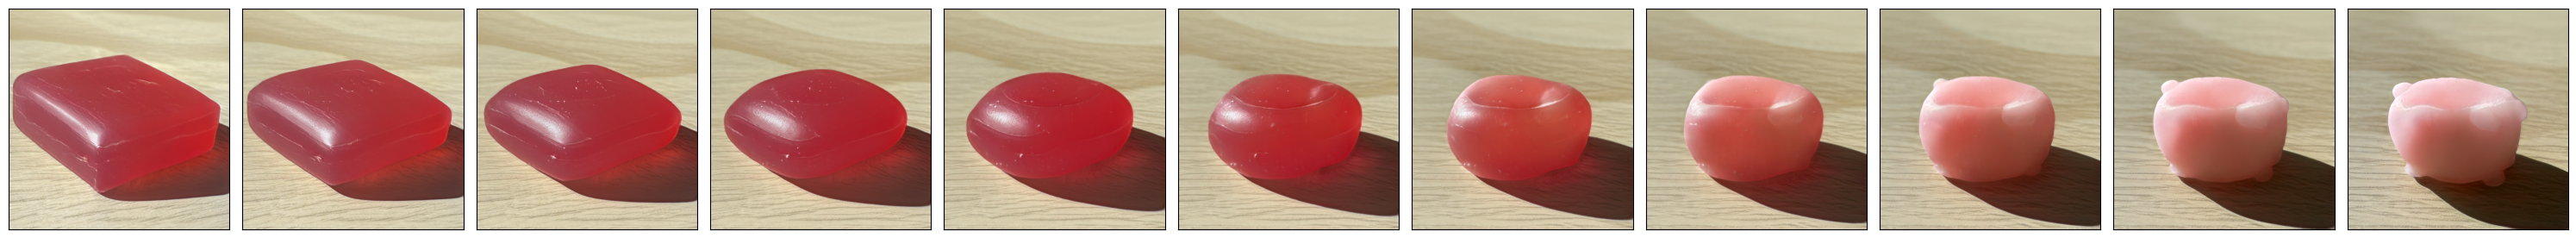

In [14]:
## Please run a GPU
## On a Telsa T4, creating a 41-step morphing sequence takes about 3m4s
if __name__ == "__main__":
  lighting = "strong" # either 'low' or 'strong'
  from_material = "soap"
  to_material =   "toy"
  source_seed = 16 #see examples from material_latent_code_W
  target_seed = 7

  num_step = 11 #define the morphing step
  base_path =  "/content/drive/MyDrive/Adaptation_experiments/morphing_sequences/"
  folder_name = from_material+ str(source_seed+1) + "_to_" \
                  + to_material + str(target_seed+1) + "_" + lighting
  outdir = os.path.join(base_path, folder_name)
  print("saved to folder:", outdir)
  morphed_layer = "all" #morph all generative layers and latent code layers
  res_imgs = Morph_Material(
                   f"{from_material}_{lighting}",
                   source_seed,
                   f"{to_material}_{lighting}",
                   target_seed,
                   num_step,
                   morphed_layer,
                   save_path = outdir,
                   save_flag = False
                   )
  plot_subplot(res_imgs, n_row=1, n_col=num_step, height = 20, width=30)

